In [2]:
#https://github.com/blei-lab/edward/blob/master/examples/getting_started_example.py
%matplotlib inline

"""
Bayesian neural network using mean-field variational inference.
(see, e.g., Blundell et al. (2015); Kucukelbir et al. (2016))
Inspired by autograd's Bayesian neural network example.
Probability model:
  Bayesian neural network
  Prior: Normal
  Likelihood: Normal with mean parameterized by fully connected NN
Variational model
  Likelihood: Mean-field Normal
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function



import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Variational, Normal
from edward.stats import norm

plt.style.use('ggplot')


In [3]:
class BayesianNN:
  """
  Bayesian neural network for regressing outputs y on inputs x.
  p((x,y), z) = Normal(y | NN(x; z), lik_variance) *
          Normal(z | 0, 1),
  where z are neural network weights, and with known lik_variance.
  Parameters
  ----------
  layer_sizes : list
    The size of each layer, ordered from input to output.
  nonlinearity : function, optional
    Non-linearity after each linear transformation in the neural
    network; aka activation function.
  lik_variance : float, optional
    Variance of the normal likelihood; aka noise parameter,
    homoscedastic variance, scale parameter.
  """
  def __init__(self, layer_sizes, nonlinearity=tf.nn.tanh,
               lik_variance=0.01):
    self.layer_sizes = layer_sizes
    self.nonlinearity = nonlinearity
    self.lik_variance = lik_variance

    self.n_layers = len(layer_sizes)
    self.weight_dims = list(zip(layer_sizes[:-1], layer_sizes[1:]))
    self.n_vars = sum((m + 1) * n for m, n in self.weight_dims)

  def unpack_weights(self, z):
    """Unpack weight matrices and biases from a flattened vector."""
    for m, n in self.weight_dims:
      yield tf.reshape(z[:m * n], [m, n]), \
          tf.reshape(z[m * n:(m * n + n)], [1, n])
      z = z[(m + 1) * n:]

  def neural_network(self, x, zs):
    """
    Return a `n_samples` x `n_minibatch` matrix. Each row is
    the output of a neural network on the input data `x` and
    given a set of weights `z` in `zs`.
    """
    matrix = []
    for z in tf.unpack(zs):
      # Calculate neural network with weights given by `z`.
      h = x
      for W, b in self.unpack_weights(z):
        # broadcasting to do (h*W) + b (e.g. 40x10 + 1x10)
        h = self.nonlinearity(tf.matmul(h, W) + b)

      matrix += [tf.squeeze(h)]  # n_minibatch x 1 to n_minibatch

    return tf.pack(matrix)

  def log_lik(self, xs, zs):
    """Return a vector [log p(xs | zs[1,:]), ..., log p(xs | zs[S,:])]."""
    x, y = xs['x'], xs['y']
    mus = self.neural_network(x, zs)
    log_lik = tf.reduce_sum(norm.logpdf(y, loc=mus, scale=self.lik_variance), 1)
    return log_lik

In [4]:
def build_toy_dataset(N=50, noise_std=0.1):
  x = np.linspace(-3, 3, num=N)
  y = np.cos(x) + norm.rvs(0, noise_std, size=N)
  x = x.reshape((N, 1))
  return {'x': x, 'y': y}


ed.set_seed(42)

model = BayesianNN(layer_sizes=[1, 2, 2, 1])

variational = Variational()
variational.add(Normal(model.n_vars))

data = build_toy_dataset()

inference = ed.MFVI(model, variational, data)
inference.initialize()


sess = ed.get_session()


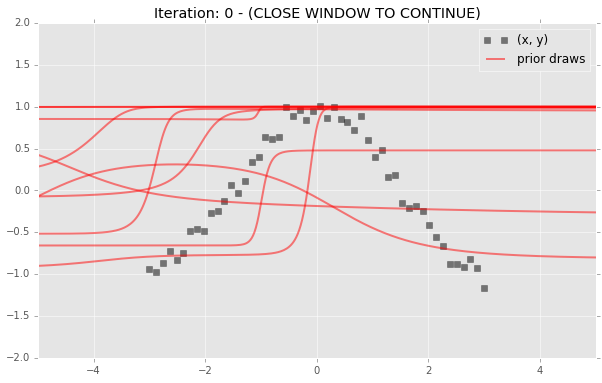

In [5]:
# FIRST VISUALIZATION (prior)

# Sample functions from variational model
mean, std = sess.run([variational.layers[0].loc,
                      variational.layers[0].scale])
rs = np.random.RandomState(0)
zs = rs.randn(10, variational.n_vars) * std + mean
zs = tf.constant(zs, dtype=tf.float32)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(tf.constant(inputs), 1)
mus = model.neural_network(x, zs)
outputs = mus.eval()
x, y = data['x'], data['y']

# Plot data and functions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0 - (CLOSE WINDOW TO CONTINUE)")
ax.plot(x, y, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()


iter 0 loss -218933.00
mean: 
[ 1.03243911  0.58332241  1.33028758  1.39758205  0.72399122 -2.11409569
 -0.73806763  0.589306    2.3092103   1.42887747  0.69088209 -1.08094847
  0.21158841]
std dev: 
[ 0.77058643  0.51832908  0.0584924   1.34706461  0.57293272  1.01566124
  0.93993533  0.47655565  0.41482449  1.46792555  0.07115243  0.41334188
  0.2673516 ]
iter 100 loss -17324.88
mean: 
[ 1.91236603  2.32773542  2.42086792 -3.27937818  2.59846544 -2.33608961
  0.54065311  2.51100802  2.01132393  1.61948764 -0.09265073 -0.99782187
 -0.04223328]
std dev: 
[ 0.07013885  0.05412529  0.02831417  0.22810359  0.31253135  0.1723057
  0.24760698  0.12363227  0.11895071  0.23800761  0.0107217   0.0328409
  0.02473178]
iter 200 loss -8684.70
mean: 
[ 1.09951282  1.68588006  1.66464436 -2.68281627  2.55867147 -1.12397587
  0.27627429  1.24045181  2.26791143  1.54754341  0.23057128 -1.25938725
  0.05168733]
std dev: 
[ 0.03904838  0.02732696  0.01324545  0.07604794  0.28536817  0.06902967
  0.2314

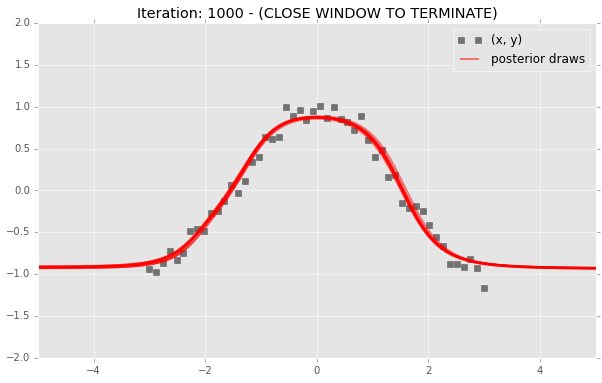

In [6]:
# RUN MEAN-FIELD VARIATIONAL INFERENCE
inference.run(n_iter=1000, n_samples=5, n_print=100)


# SECOND VISUALIZATION (posterior)

# Sample functions from variational model
mean, std = sess.run([variational.layers[0].loc,
                      variational.layers[0].scale])
rs = np.random.RandomState(0)
zs = rs.randn(10, variational.n_vars) * std + mean
zs = tf.constant(zs, dtype=tf.float32)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(tf.constant(inputs), 1)
mus = model.neural_network(x, zs)
outputs = mus.eval()
x, y = data['x'], data['y']

# Plot data and functions
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000 - (CLOSE WINDOW TO TERMINATE)")
ax.plot(x, y, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()